In [44]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from datetime import datetime


In [53]:
def plot_training(file, title):

    hist = pd.read_csv(file, index_col=0)
    hist = hist.to_dict('split')
    hist = dict(zip(hist['index'],hist['data']))

    plt.plot(hist['accuracy'],label='training')
    plt.plot(hist['val_accuracy'], label='validation')
    plt.legend()
    plt.title(title + ' Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.savefig(title + '_Accuracy_' + str(datetime.now()) + '.png')
    plt.show()

    plt.plot(hist['loss'],label='training')
    plt.plot(hist['val_loss'], label='validation')
    plt.legend()
    plt.title(title + ' Loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.savefig(title + '_Loss_' + str(datetime.now()) + '.png')
    plt.show()

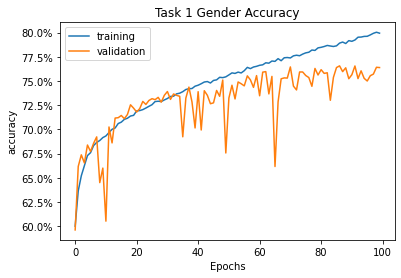

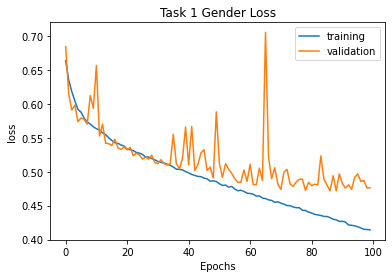

In [54]:
plot_training('task_1_gender.csv', 'Task 1 Gender')

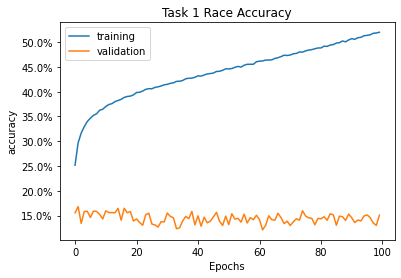

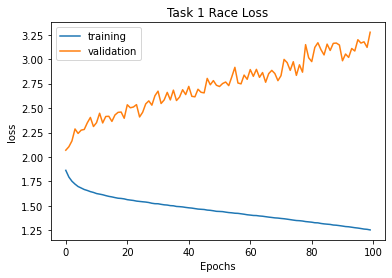

In [41]:
plot_training('task_1_race.csv', 'Task 1 Race')

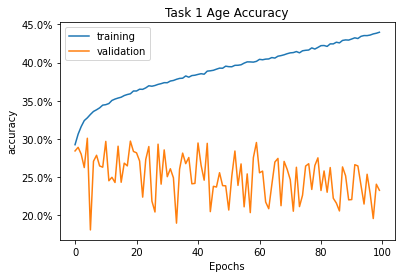

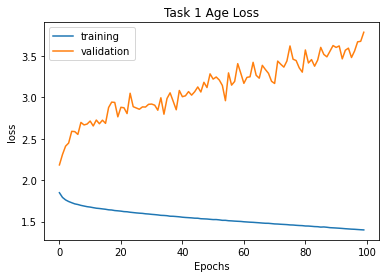

In [42]:
plot_training('task_1_age.csv', 'Task 1 Age')